## Data preprocessing

In [11]:
import nltk
import string
import numpy as np
%matplotlib inline
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

enstop = stopwords.words('english')
punct = string.punctuation

def tokenizer(sent):
    sent = sent.lower()
    tmp = word_tokenize(sent)
    res = []
    for word in tmp:
        if word not in enstop and word not in punct:
            res.append(word)
    return res

### IMDB data read:

In [12]:
import torch
import torch.nn as nn
from torchtext import data
from torchtext import vocab

text_field = data.Field(tokenize=tokenizer, lower=True, include_lengths=True, fix_length=256)
label_field = data.Field(sequential=False, use_vocab=False, dtype=torch.long)
train, valid, test = data.TabularDataset.splits(path='',
                                                train='./data/Train.csv',
                                                validation='./data/Valid.csv',
                                                test='./data/Test.csv',
                                                format='csv', skip_header=True,
                                                fields=[('sentence', text_field), ('label', label_field)])

### Read the GloVe word vector:

In [13]:
vec = vocab.Vectors(name='glove.6B.300d.txt')
text_field.build_vocab(train, valid, test, max_size=80000, vectors=vec,
                       unk_init=torch.Tensor.normal_)
label_field.build_vocab(train, valid, test)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_sizes=(128, 128, 128),
                                                               sort_key=lambda x: len(x.sentence),
                                                               sort_within_batch=True,
                                                               repeat=False, shuffle=True,
                                                               device=device)

### Model training function (standard training and DropAttack adversarial training)

In [15]:
def train_fun(model, train_iter, dev_iter, num_epoch, opt, criterion, eva,
              out_model_file):
    model.train()
    loss_list = []
    dev_acc = []
    train_acc = []
    best_dev_acc = 0.
    for epoch in range(num_epoch):
        total_loss = 0.
        for batch in train_iter:
            opt.zero_grad()
            output = model(batch.sentence)
            loss = criterion(output, batch.label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        loss_list.append(total_loss)
        dev_acc.append(eva(model, dev_iter))
        train_acc.append(eva(model,train_iter))
        print(f"Epoch: {epoch+1}/{num_epoch}. Total loss: {total_loss:.3f}.Train_Acc: {train_acc[-1]:.3%}. Validation Set Acc: {dev_acc[-1]:.3%}.")
        if dev_acc[-1] > best_dev_acc:
            best_dev_acc = dev_acc[-1]
            torch.save(model.state_dict(), out_model_file)
    return loss_list, dev_acc

In [16]:
def train(model, train_iter, dev_iter, num_epoch, opt, criterion, eva, out_model_file):
    print("Training begin!")
    model.train()
    loss_list = []
    dev_acc = []
    train_acc = []
    best_dev_acc = 0.
    for epoch in range(num_epoch):
        total_loss = 0.
        for batch in train_iter:
            output = model(batch.sentence)
            loss = criterion(output, batch.label)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        loss_list.append(total_loss)
        dev_acc.append(eva(model, dev_iter))
        train_acc.append(eva(model,train_iter))
        print(f"Epoch: {epoch+1}/{num_epoch}. Total loss: {total_loss:.3f}.Train_Acc: {train_acc[-1]:.3%}. Validation Set Acc: {dev_acc[-1]:.3%}.")
        if dev_acc[-1] > best_dev_acc:
            best_dev_acc = dev_acc[-1]
            torch.save(model.state_dict(), out_model_file)
    return loss_list, dev_acc
# import torch
class DropAttack():
    def __init__(self, model):
        self.model = model
        self.param_backup = {}
        self.grad_backup = {}
        self.mask_backup = {}

    def attack(self, epsilon=5.0, p_attack =0.5, param_name='embed.weight', is_first_attack=False):
        # The emb_name parameter should be replaced with the name of the parameter to be attacked in your model
        for name, param in self.model.named_parameters():
            if param.requires_grad and param_name == name:
                if is_first_attack:
                    self.param_backup[name] = param.data.clone()
                    mask = np.random.binomial(n=1, p=p_attack, size= param.grad.shape)
                    mask = torch.from_numpy(mask).float()  # attack mask
                    self.mask_backup['mask'] = mask.clone()
                else: mask = self.mask_backup['mask']
                norm = torch.norm(param.grad)
                if norm != 0 and not torch.isnan(norm):
                    r_at = epsilon * param.grad / norm
                    r_at *= mask.cuda()   # Randomly attack some of the parameters
                    param.data.add_(r_at)    

    def restore(self, param_name='embed.weight'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param_name == name: 
                assert name in self.param_backup
                param.data = self.param_backup[name]
                param_backup = {}

    def backup_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.grad_backup[name] = param.grad.clone()

    def restore_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.grad = self.grad_backup[name]
                grad_backup = {}
        
def train_DA(model, train_iter, dev_iter, num_epoch, opt, criterion, eva, out_model_file):
    K = 3
    print(f'Adversarial training begin! (DropAttack-{K})')
    model.train()
    dropattack = DropAttack(model)
    loss_list = []
    dev_acc = []
    best_dev_acc = 0.
    for epoch in range(num_epoch):
        total_loss = 0.
        model.train()
        for batch in train_iter:
            output = model(batch.sentence)
            loss = criterion(output, batch.label)
            loss.backward(retain_graph=True)  # Calculate the original gradient
            dropattack.backup_grad()    # Backup the initial gradient
            # Attack the embedding layer
            for t in range(K):
                dropattack.attack(5, 0.5, 'embed.weight', is_first_attack=(t==0))  # Add adversarial disturbance to the parameters, backup param.data for the first attack
                output = model(batch.sentence)
                loss_adv1 = criterion(output, batch.label)/K
                loss_adv1.backward(retain_graph=True) # # Backpropagation, and accumulate the gradient of the adversarial training based on the normal grad
                loss += loss_adv1
            dropattack.restore('embed.weight') # # Restore the disturbed parameters
            
            dropattack.restore_grad() 
            # Attack the hidden layer
            for t in range(K):
                dropattack.attack(5, 0.5, 'rnn.rnn.weight_ih_l0', is_first_attack=(t==0)) # Add adversarial disturbance to the parameters, backup param.data for the first attack
                output = model(batch.sentence)
                loss_adv2 = criterion(output, batch.label)/K
                loss_adv2.backward(retain_graph=True) # Backpropagation, and accumulate the gradient of the adversarial training based on the normal grad
                loss += loss_adv2
            dropattack.restore('rnn.rnn.weight_ih_l0') # Restore the disturbed parameters
            opt.zero_grad()
            
            loss.backward()
            opt.step()  # Update parameters
            # loss = loss + loss_adv1 + loss_adv2
            total_loss += loss.item()
            opt.zero_grad()
        loss_list.append(total_loss)
        dev_acc.append(eva(model, dev_iter))
        print(f"Epoch: {epoch+1}/{num_epoch}. Total loss: {total_loss:.3f}. Validation Set Acc: {dev_acc[-1]:.3%}.")
        if dev_acc[-1] > best_dev_acc:
            best_dev_acc = dev_acc[-1]
            torch.save(model.state_dict(), out_model_file)
    return loss_list, dev_acc



In [17]:
def eva(model, data_iter):
    correct, count = 0, 0
    with torch.no_grad():
        for batch in data_iter:
            pred = model(batch.sentence)
            pred = torch.argmax(pred, dim=-1)
            correct += (pred == batch.label).sum().item()
            count += len(pred)
    return correct / count

### LSTM model

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, bidirectional=bidirectional)
            
    def forward(self, x, length):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, length)
        packed_output, (hidden, cell) = self.rnn(packed_x)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        return hidden, output

In [23]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional)
            
    def forward(self, x, length):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, length)
        packed_output, hidden = self.rnn(packed_x)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        return hidden, output

In [24]:
class TextRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, bidirectional, out_dim,
                 pretrained_embed, use_gru=False, freeze=True,
                 random_embed=False, vocab_size=None):
        super(TextRNN, self).__init__()
        if random_embed:
            self.embed = nn.Embedding(vocab_size, embed_size)
        else:
            self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=False)
        if use_gru:
            self.rnn = GRU(embed_size, hidden_size, num_layers, bidirectional)
        else:
            self.rnn = LSTM(embed_size, hidden_size, num_layers, bidirectional)
        self.proj = nn.Linear(hidden_size, out_dim)
    
    def forward(self, x):
        text, text_length = x # text: [seq_len, bs]
        text = text.permute(1, 0) # text: [bs, seq_len]
        embed_x = self.embed(text) # embed_x: [bs, seq_len, embed_dim]
        embed_x = embed_x.permute(1, 0, 2) # embed_x: [seq_len, bs, embed_dim]
        hidden, _ = self.rnn(embed_x, text_length) # hidden: [num_layers, bs, hidden_size]
        hidden = hidden[-1,:,:]
        return self.proj(hidden)

### Training

In [26]:
embed_size = 300
hidden_size = 300
num_layers = 1
bidirectional = False
out_dim = 2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 5
freeze = False
use_gru = False
random_embed = False
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_IMDB-AT-vis.pt'
# ————————————————————————————————————————————————————————
use_dropattack = True   # Whether to use DropAttack
# ————————————————————————————————————————————————————————
model = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                                pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

if use_dropattack:
    loss_list, dev_acc_list = train_DA(model, train_iter, valid_iter, num_epoch, opt, criterion, eva, out_model_file)
else:
    loss_list, dev_acc_list = train(model, train_iter, valid_iter, num_epoch, opt, criterion, eva, out_model_file)

Adversarial training begin! (DropAttack-3)
Epoch: 1/5. Total loss: 659.107. Validation Set Acc: 52.680%.
Epoch: 2/5. Total loss: 525.388. Validation Set Acc: 88.440%.
Epoch: 3/5. Total loss: 275.596. Validation Set Acc: 90.980%.
Epoch: 4/5. Total loss: 164.434. Validation Set Acc: 90.900%.
Epoch: 5/5. Total loss: 99.363. Validation Set Acc: 90.360%.


In [27]:
model = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
model.load_state_dict(torch.load('textrnn_IMDB-AT-vis.pt'))
print(f"Test set acc: {eva(model, test_iter):.3%}")

Test set acc: 90.700%


## Visualization of LOSS function

In [69]:
# Create a random direction
def create_random_directions(model):
    x_direction = create_random_direction(model)
    y_direction = create_random_direction(model)

    return [x_direction, y_direction]


def create_random_direction(model):
    weights = get_weights(model)
    direction = get_random_weights(weights)
    normalize_directions_for_weights(direction, weights)

    return direction


def get_weights(model):
    return [p.data for p in model.parameters()]


def get_random_weights(weights):
    return [torch.randn(w.size()) for w in weights]


def normalize_direction(direction, weights):
    for d, w in zip(direction, weights):
        d.mul_(w.norm() / (d.norm() + 1e-10))


def normalize_directions_for_weights(direction, weights):
    assert (len(direction) == len(weights))
    for d, w in zip(direction, weights):
        normalize_direction(d, w)

In [70]:
model = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                                pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
rand_directions = create_random_directions(model)

In [71]:
def load_model():
    model.load_state_dict(torch.load('textrnn_IMDB-AT-vis.pt'))
    return model

trained_model = load_model()

In [72]:
import torch
import torch.nn as nn
from torch.autograd.variable import Variable


def eval_loss(model):

    criterion = nn.CrossEntropyLoss()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    correct = 0
    total_loss = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_iter):
            batch_size = 128
            total += batch_size
            inputs = batch.sentence
            targets = batch.label
#             if torch.cuda.is_available():
#                 inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets).sum().item()

    return total_loss / total, 100. * correct / total

# for epoch in range(num_epoch):
#         total_loss = 0.
#         for batch in train_iter:
#             opt.zero_grad()
#             output = model(batch.sentence)
#             loss = criterion(output, batch.label)

In [77]:
import torch
import numpy as np
import h5py
import os



def calulate_loss_landscape(model, directions):
    setup_surface_file()
    init_weights = [p.data for p in model.parameters()]

    with h5py.File("./3d_surface_file-da.h5", 'r+') as f:

        xcoordinates = f['xcoordinates'][:]
        ycoordinates = f['ycoordinates'][:]
        losses = f["test_loss"][:]
        accuracies = f["test_acc"][:]

        inds, coords = get_indices(losses, xcoordinates, ycoordinates)

        for count, ind in enumerate(inds):
            print("ind...%s" % ind)
            coord = coords[count]
            overwrite_weights(model, init_weights, directions, coord)

            loss, acc = eval_loss(model)
            print(loss, acc)

            losses.ravel()[ind] = loss
            accuracies.ravel()[ind] = acc

            print('Evaluating %d/%d  (%.1f%%)  coord=%s' % (
                ind, len(inds), 100.0 * count / len(inds), str(coord)))

            f["test_loss"][:] = losses
            f["test_acc"][:] = accuracies
            f.flush()

            #if ind % 300 == 0:
            #    break

def setup_surface_file():
    xmin, xmax, xnum = -1.5, 1.5, 51
    ymin, ymax, ynum = -1.5, 1.5, 51

    surface_path = "./3d_surface_file-da.h5"

    if os.path.isfile(surface_path):
        print("%s is already set up" % "3d_surface_file-da.h5")

        return

    with h5py.File(surface_path, 'a') as f:
        print("create new 3d_sureface_file-da.h5")

        xcoordinates = np.linspace(xmin, xmax, xnum)
        f['xcoordinates'] = xcoordinates

        ycoordinates = np.linspace(ymin, ymax, ynum)
        f['ycoordinates'] = ycoordinates

        shape = (len(xcoordinates), len(ycoordinates))
        losses = -np.ones(shape=shape)
        accuracies = np.ones(shape=shape)

        f["test_loss"] = losses
        f["test_acc"] = accuracies

        return


def get_indices(vals, xcoordinates, ycoordinates):
    inds = np.array(range(vals.size))
    inds = inds[vals.ravel() <= 0]

    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
    s1 = xcoord_mesh.ravel()[inds]
    s2 = ycoord_mesh.ravel()[inds]

    return inds, np.c_[s1, s2]


def overwrite_weights(model, init_weights, directions, step):
    dx = directions[0]
    dy = directions[1]
    changes = [d0 * step[0] + d1 * step[1] for (d0, d1) in zip(dx, dy)]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for (p, w, d) in zip(model.parameters(), init_weights, changes):
        p.data = w.to(device) + torch.Tensor(d).to(device)

In [ ]:
calulate_loss_landscape(trained_model, rand_directions)

create new 3d_sureface_file-da.h5
ind...0
0.3185126166790724 84.9609375
Evaluating 0/2601  (0.0%)  coord=[-1.5 -1.5]
ind...1
0.31326639875769613 85.33203125
Evaluating 1/2601  (0.0%)  coord=[-1.44 -1.5 ]
ind...2
0.30845997855067253 85.80078125
Evaluating 2/2601  (0.1%)  coord=[-1.38 -1.5 ]
ind...3
0.304076935723424 85.9765625
Evaluating 3/2601  (0.1%)  coord=[-1.32 -1.5 ]
ind...4
0.3001474436372519 86.15234375
Evaluating 4/2601  (0.2%)  coord=[-1.26 -1.5 ]
ind...5
0.29664432257413864 86.3671875
Evaluating 5/2601  (0.2%)  coord=[-1.2 -1.5]
ind...6
0.2935148760676384 86.50390625
Evaluating 6/2601  (0.2%)  coord=[-1.14 -1.5 ]
ind...7
0.29076419286429883 86.4453125
Evaluating 7/2601  (0.3%)  coord=[-1.08 -1.5 ]
ind...8
0.2883039452135563 86.5625
Evaluating 8/2601  (0.3%)  coord=[-1.02 -1.5 ]
ind...9
0.2860392309725285 86.5625
Evaluating 9/2601  (0.3%)  coord=[-0.96 -1.5 ]
ind...10
0.28393469005823135 86.69921875
Evaluating 10/2601  (0.4%)  coord=[-0.9 -1.5]
ind...11
0.2819462105631828 86.7

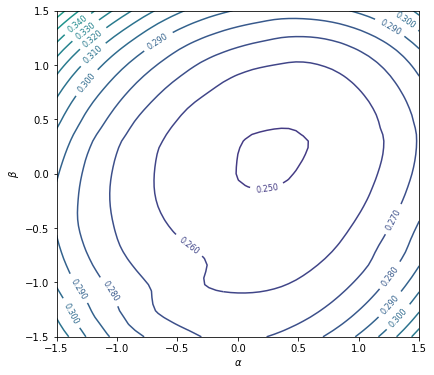

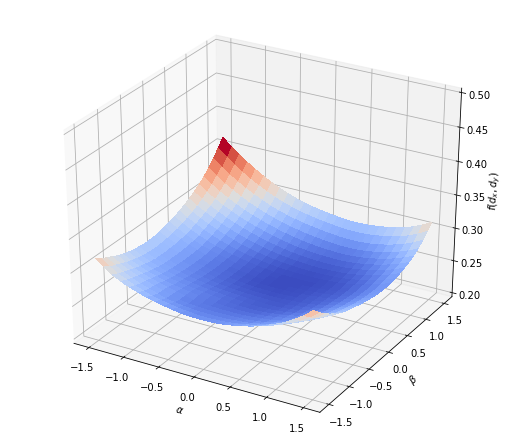

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import h5py
import numpy as np
import seaborn as sns
from matplotlib import cm
plt.rc('font',family='Times New Roman')

def visualize():

    vmin = 0.2
    vmax = 0.5
    vlevel = 0.01
    result_file_path = "./3d_surface_file-da.h5"
    surf_name = "test_loss"

    with h5py.File("./3d_surface_file-da.h5",'r') as f:

        Z_LIMIT = 10

        x = np.array(f['xcoordinates'][:])
        y = np.array(f['ycoordinates'][:])

        X, Y = np.meshgrid(x, y)
        Z = np.array(f[surf_name][:])
        #Z[Z > Z_LIMIT] = Z_LIMIT
        #Z = np.log(Z)  # logscale
        
        #  2D loss
        fig = plt.figure(figsize=(6.5, 6))
        
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$\beta$')
        
        CS = plt.contour(X, Y, Z, plt.get_cmap('rainbow'), levels=np.arange(vmin, vmax, vlevel))
        plt.clabel(CS, inline=1, fontsize=8)
        fig.savefig(result_file_path + '_' + surf_name + '_2dcontour' + '.png', dpi=500,
                    bbox_inches='tight', format='png')
        # 3D loss
        fig = plt.figure(figsize=(7, 6))
        ax = Axes3D(fig)
        ax.set_xlabel(r"$\alpha$")
        ax.set_ylabel(r"$\beta$")
        ax.set_zlabel(r"$f(d_x,d_y)$")
        #ax.plot_wireframe(X, Y, Z)
#         ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=2, antialiased=False,)
        ax.set_zlim(vmin, vmax)
        plt.show()
        fig.savefig(result_file_path + '_' + surf_name + '_3dsurface.png', dpi=500,
                    bbox_inches='tight', format='png')
        

        

visualize()


